# Seasonal ARIMA (SARIMA) Model to Forecast Temperature

In [91]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

Task: 
What would we like to predict?
How far into the future?

## Load Data

In [109]:
# parse the DWD dataset and convert date and align with home readings 
# Format dwd: yyyymmddhh
df = pd.read_csv('/Users/stewarta/repos/iot-htsensor/data/produkt_tu_stunde_19510101_20171231_00662.txt', sep=';')

# parse date, insert as column for sanity checking
df.insert(2, 'datetime', pd.to_datetime(df['MESS_DATUM'], errors='coerce', format='%Y%m%d%H'))

# create index
df.set_index('datetime', inplace=True)

# extract relevant columns and rename
df.rename(columns={'TT_TU':'D_Temp','RF_TU':'D_Humi'}, inplace=True)

# filter years
filter = (df.index >= '2010-01-01') & (df.index <= '2016-06-15') 

# filter columns
df = df.loc[filter,['D_Temp', 'D_Humi']]

# resample
frequency = 'M'
df = df.resample(frequency).mean()

# interpolate missing values
df = df.interpolate()

## fill na with mean valued :: df.resample("1d").sum().fillna(0).rolling(window=3, min_periods=1).mean()

df.head()

,D_Temp,D_Humi
datetime,,
2010-01-31,-3.879973,86.928763
2010-02-28,-0.284673,82.645833
2010-03-31,4.991398,75.493280
2010-04-30,9.473333,64.016667
2010-05-31,10.425134,79.571237


In [97]:
df.shape

(78, 2)

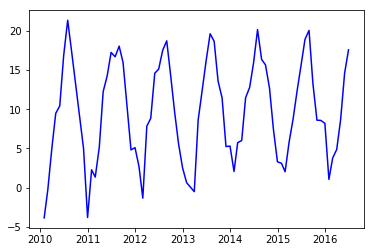

In [98]:
# Plot Data
# Question: What Model should we use to make forecasts given the following plot?
plt.plot(df.D_Temp, color='blue')

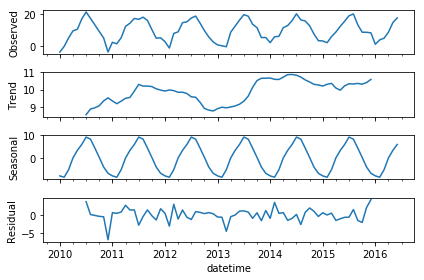

In [99]:
# Question: Does the series have a trend?
## Decompose
result = seasonal_decompose(df.D_Temp)
result.plot()
plt.show()

## SARIMA

Trend Elements
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.

Seasonal Elements
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period

## Trend Elements
Question: A stationary series has no trend, its variations around its mean have a constant amplitude

### Testing Stationary

Null Hypothesis (H0): If failed to be rejected, it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series is stationary. It does not have time-dependent structure.

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [100]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd =  timeseries.rolling(10).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )

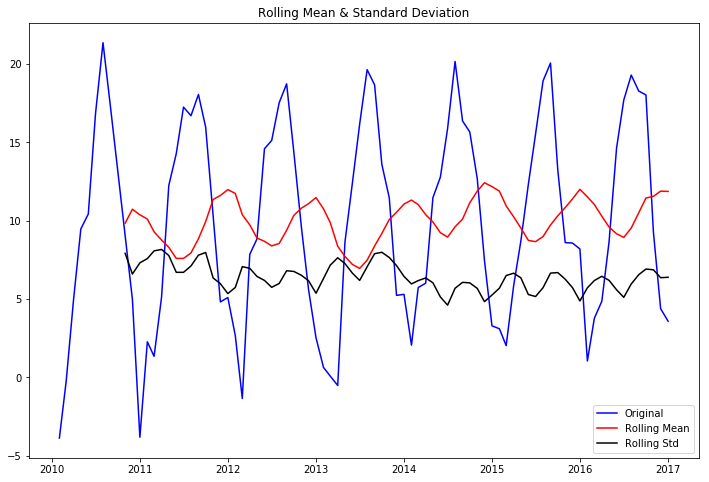

Results of Dickey-Fuller Test:
Test Statistic                -9.046217e+00
p-value                        4.978620e-15
#Lags Used                     5.000000e+00
Number of Observations Used    7.800000e+01
Critical Value (1%)           -3.517114e+00
Critical Value (5%)           -2.899375e+00
Critical Value (10%)          -2.586955e+00
dtype: float64


In [15]:
test_stationarity(df.D_Temp)

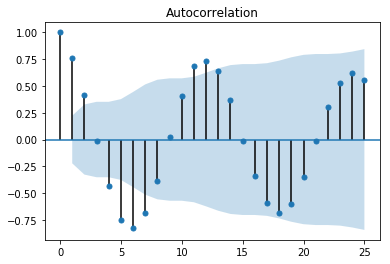

In [102]:
plot_acf(df.D_Temp, lags=25)
plt.show()

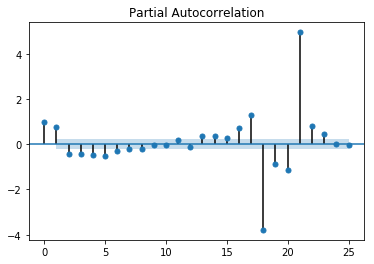

In [103]:
plot_pacf(df.D_Temp, lags=25)
plt.show()

### Train SARIMA Model

In [110]:
import statsmodels.api as sm  
mod = sm.tsa.statespace.SARIMAX(df['D_Temp'],trend='n', order=(0,1,0), seasonal_order=(0,1,1,12) )
#mod = sm.tsa.statespace.SARIMAX(df['D_Temp'] )
results = mod.fit()

## Forecast Future Values

In [111]:
predictions = results.predict(start=78, end=102, dynamic=True) 
# create dataframe of predictions for convenience. 
df_predictions = pd.DataFrame(predictions, columns=['forecast'])
print('The predictions are:')
df_predictions

The predictions are:


,forecast
2016-07-31,20.507094
2016-08-31,19.646112
2016-09-30,15.797794
2016-10-31,11.734352
2016-11-30,7.558468
2016-12-31,4.879620
2017-01-31,3.409489
2017-02-28,3.900029
2017-03-31,7.164117
2017-04-30,12.002342


## Plots Forecast Results

,D_Humi,D_Temp,forecast
2018-03-31,NaN,NaN,8.205285
2018-04-30,NaN,NaN,13.043511
2018-05-31,NaN,NaN,16.390547
2018-06-30,NaN,NaN,19.670764
2018-07-31,NaN,NaN,22.589431


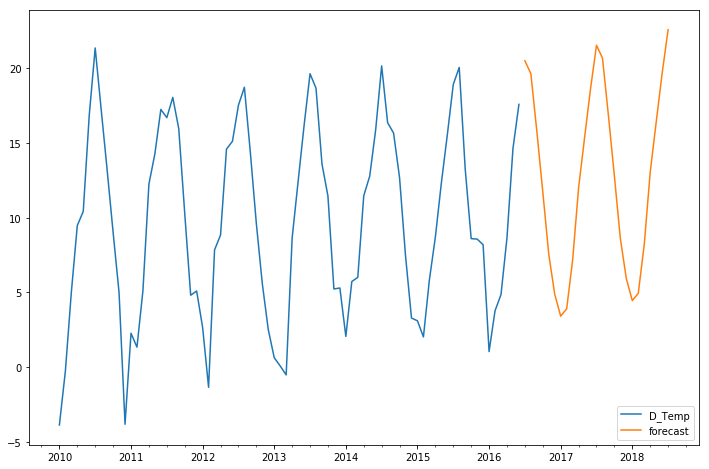

In [113]:
# peak at the results
df_final = df.append(pd.DataFrame(df_predictions), ignore_index=False, sort=True)
# print original data and forecast: 
df_final[['D_Temp', 'forecast']].plot(figsize=(12, 8)) 
df_final.tail()